In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import load_model
from keras.layers.recurrent import GRU
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import math
plt.style.use('fivethirtyeight')
%matplotlib inline

Using TensorFlow backend.


In [4]:
df = pd.read_csv('KBANK.csv')
df.head()

,Date,KBANKOpen,KBANKHigh,KBANKLow,KBANKClose,KBANKVolume,KBANKAdjusted
0,5/1/2015,226.0,227.0,220.0,220.0,8257400,189.366287
1,6/1/2015,214.0,215.0,205.0,214.0,14103900,184.201767
2,7/1/2015,215.0,219.0,214.0,218.0,8669900,187.644775
3,8/1/2015,223.0,228.0,222.0,228.0,8947000,196.252335
4,9/1/2015,230.0,231.0,227.0,229.0,6858000,197.113113


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1219 non-null   object 
 1   KBANKOpen      1219 non-null   float64
 2   KBANKHigh      1219 non-null   float64
 3   KBANKLow       1219 non-null   float64
 4   KBANKClose     1219 non-null   float64
 5   KBANKVolume    1219 non-null   int64  
 6   KBANKAdjusted  1219 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 66.8+ KB


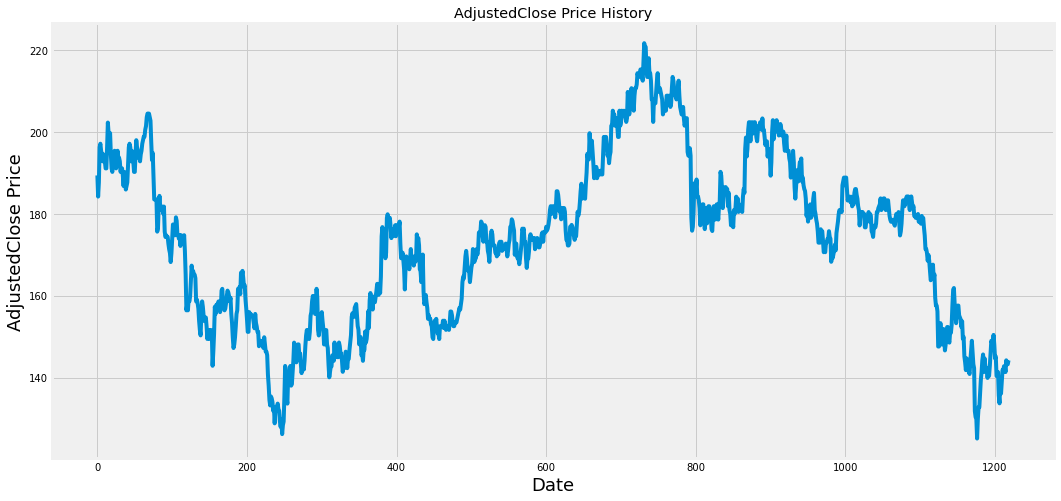

In [6]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('AdjustedClose Price History')
plt.plot(df['KBANKAdjusted'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('AdjustedClose Price',fontsize=18)
plt.show()

In [7]:
# Correlation matrix
df.corr()['KBANKAdjusted']

KBANKOpen        0.960546
KBANKHigh        0.962151
KBANKLow         0.964747
KBANKClose       0.965534
KBANKVolume     -0.258274
KBANKAdjusted    1.000000
Name: KBANKAdjusted, dtype: float64

In [8]:
input_feature= df.iloc[:,[1,2,3,4,6,]].values
input_data = input_feature
input_data

array([[226.      , 227.      , 220.      , 220.      , 189.366287],
       [214.      , 215.      , 205.      , 214.      , 184.201767],
       [215.      , 219.      , 214.      , 218.      , 187.644775],
       ...,
       [151.      , 151.5     , 149.5     , 150.      , 143.25    ],
       [151.      , 151.5     , 149.      , 150.      , 143.25    ],
       [150.      , 152.      , 150.      , 151.      , 144.205002]])

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
input_data = scaler.fit_transform(input_data)
input_data

array([[0.84684685, 0.83486239, 0.80995475, 0.8018018 , 0.66549499],
       [0.73873874, 0.72477064, 0.67420814, 0.74774775, 0.61201081],
       [0.74774775, 0.76146789, 0.75565611, 0.78378378, 0.64766688],
       ...,
       [0.17117117, 0.14220183, 0.1719457 , 0.17117117, 0.18791109],
       [0.17117117, 0.14220183, 0.16742081, 0.17117117, 0.18791109],
       [0.16216216, 0.14678899, 0.17647059, 0.18018018, 0.19780117]])

In [10]:
lookback= 60

train_size=int(.8 * len(df))
X=[]
Y=[]
for i in range(len(df)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    Y.append(input_data[i+ lookback,4])

In [11]:
X, y= np.array(X), np.array(Y)
print(X.shape)
print(y.shape)

(1158, 60, 1, 5)
(1158,)


In [12]:
x_training_set= X[:train_size]
x_test_set=X[train_size+lookback:]
x_test_set = x_test_set.reshape(x_test_set.shape[0],lookback, 5)
x_training_set = x_training_set.reshape(x_training_set.shape[0],lookback, 5)
print(x_test_set.shape)
print(x_training_set.shape)

(123, 60, 5)
(975, 60, 5)


In [13]:
y_training_set= y[:train_size]
y_test_set=y[train_size+lookback:]
print(y_training_set.shape)
print(y_test_set.shape)

(975,)
(123,)


In [14]:
y_test = y_test_set.reshape(-1,1)
y_test.shape

(123, 1)

# RNN Model

In [15]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(30, return_sequences= True, input_shape=(x_training_set.shape[1],5))) 
rnn_model.add(SimpleRNN(30, return_sequences= True))
rnn_model.add(SimpleRNN(30))
rnn_model.add(Dense(1) ) # output
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 60, 30)            1080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60, 30)            1830      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 4,771
Trainable params: 4,771
Non-trainable params: 0
_________________________________________________________________


In [16]:
sgd = optimizers.SGD(lr=0.020, decay=1e-6, momentum=0.9, nesterov=True)
rnn_model.compile(loss='mean_squared_error', optimizer=sgd)

In [17]:
rnn_model.fit(x_training_set, y_training_set, epochs=100, batch_size=32)

Epoch 1/100
975/975 [==============================] - 5s 5ms/step - loss: 0.6372
Epoch 2/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0470
Epoch 3/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0498
Epoch 4/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0498
Epoch 5/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0363
Epoch 6/100
975/975 [==============================] - 2s 2ms/step - loss: 0.1061A: 0s - loss: 0.107
Epoch 7/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0734
Epoch 8/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0166A: 
Epoch 9/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0358
Epoch 10/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0077
Epoch 11/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0068
Epoch 12/100
975/975 [==============================] - 2s 2ms/step - loss

In [18]:
predicted_rnn= rnn_model.predict(x_test_set)
rnn_model.evaluate(x_test_set,y_test_set)

123/123 [==============================] - 0s 1ms/step


0.00599603314800718

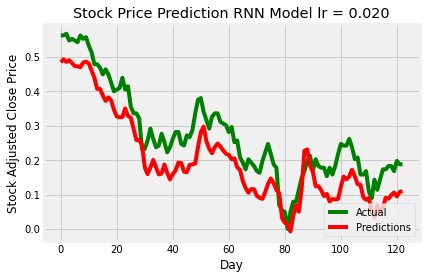

In [19]:
plt.plot(y_test, color= 'green')
plt.plot(predicted_rnn, color='red')
plt.title("Stock Price Prediction RNN Model lr = 0.020")
plt.xlabel("Day")
plt.ylabel("Stock Adjusted Close Price")
plt.legend(['Actual','Predictions'], loc='lower right')
plt.show()

# LSTM Model

In [20]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=30, return_sequences= True, input_shape=(x_training_set.shape[1],5))) 
lstm_model.add(LSTM(units=30, return_sequences= True))
lstm_model.add(LSTM(units=30))
lstm_model.add(Dense(units=1)) #output
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 30)            4320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 18,991
Trainable params: 18,991
Non-trainable params: 0
_________________________________________________________________


In [21]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lstm_model.compile(loss='mean_squared_error', optimizer=sgd)

In [22]:
lstm_model.fit(x_training_set, y_training_set, epochs=100, batch_size=32)

Epoch 1/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0741
Epoch 2/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0214
Epoch 3/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0079
Epoch 4/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0056
Epoch 5/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0054
Epoch 6/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0052
Epoch 7/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0050
Epoch 8/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0048
Epoch 9/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0047
Epoch 10/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0045
Epoch 11/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0044
Epoch 12/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0042
Epoch 13/100


975/975 [==============================] - 3s 3ms/step - loss: 0.0025
Epoch 100/100
975/975 [==============================] - 3s 3ms/step - loss: 0.0024


In [23]:
predicted_lstm= lstm_model.predict(x_test_set)
lstm_model.evaluate(x_test_set,y_test_set)

123/123 [==============================] - 0s 3ms/step


0.007505195650718804

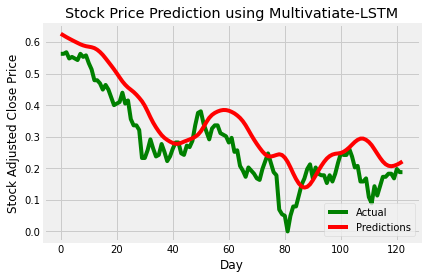

In [24]:
plt.plot(y_test, color= 'green')
plt.plot(predicted_lstm, color='red')
plt.title("Stock Price Prediction using Multivatiate-LSTM")
plt.xlabel("Day")
plt.ylabel("Stock Adjusted Close Price")
plt.legend(['Actual','Predictions'], loc='lower right')
plt.show()

# GRU Model

In [25]:
gru_model = Sequential()
gru_model.add(GRU(units=30,return_sequences=True,input_shape=(x_training_set.shape[1],5)))
gru_model.add(GRU(units=30,return_sequences=True))
gru_model.add(GRU(units=30))
gru_model.add(Dense(1))
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 60, 30)            3240      
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 30)            5490      
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [26]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
gru_model.compile(loss='mean_squared_error', optimizer=sgd)

In [27]:
gru_model.fit(x_training_set, y_training_set, epochs=100, batch_size=32)

Epoch 1/100
975/975 [==============================] - 6s 6ms/step - loss: 0.0449
Epoch 2/100
975/975 [==============================] - 4s 5ms/step - loss: 0.0045
Epoch 3/100
975/975 [==============================] - 4s 4ms/step - loss: 0.0034
Epoch 4/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0034
Epoch 5/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0033
Epoch 6/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0033
Epoch 7/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0031
Epoch 8/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0031
Epoch 9/100
975/975 [==============================] - 4s 5ms/step - loss: 0.0031
Epoch 10/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0031
Epoch 11/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0030
Epoch 12/100
975/975 [==============================] - 5s 5ms/step - loss: 0.0029
Epoch 13/100


975/975 [==============================] - 3s 3ms/step - loss: 0.0014
Epoch 100/100
975/975 [==============================] - 3s 4ms/step - loss: 0.0014


In [28]:
predicted_gru= gru_model.predict(x_test_set)
gru_model.evaluate(x_test_set,y_test_set)

123/123 [==============================] - 0s 3ms/step


0.0023421633371523

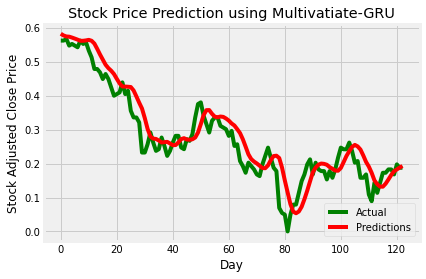

In [29]:
plt.plot(y_test, color= 'green')
plt.plot(predicted_gru, color='red')
plt.title("Stock Price Prediction using Multivatiate-GRU")
plt.xlabel("Day")
plt.ylabel("Stock Adjusted Close Price")
plt.legend(['Actual','Predictions'], loc='lower right')
plt.show()

# MLP Model

In [30]:
x_mlp = df.iloc[:,[1,2,3,4,6]]
y_mlp = df.iloc[:,6:7]
print(x_mlp)
print(y_mlp)

      KBANKOpen  KBANKHigh  KBANKLow  KBANKClose  KBANKAdjusted
0         226.0      227.0     220.0       220.0     189.366287
1         214.0      215.0     205.0       214.0     184.201767
2         215.0      219.0     214.0       218.0     187.644775
3         223.0      228.0     222.0       228.0     196.252335
4         230.0      231.0     227.0       229.0     197.113113
...         ...        ...       ...         ...            ...
1214      150.0      150.5     148.0       148.0     141.339996
1215      147.5      151.0     147.0       151.0     144.205002
1216      151.0      151.5     149.5       150.0     143.250000
1217      151.0      151.5     149.0       150.0     143.250000
1218      150.0      152.0     150.0       151.0     144.205002

[1219 rows x 5 columns]
      KBANKAdjusted
0        189.366287
1        184.201767
2        187.644775
3        196.252335
4        197.113113
...             ...
1214     141.339996
1215     144.205002
1216     143.250000
1217   

In [31]:
sc = MinMaxScaler() 
x_scaled = sc.fit_transform(x_mlp)
y_scaled = sc.fit_transform(y_mlp)

In [32]:
x_mlp_train = x_scaled[:train_size]
x_mlp_test = x_scaled[train_size:]
y_mlp_train = y_scaled[:train_size]
y_mlp_test = y_scaled[train_size:]

In [33]:
mlp_model = Sequential()
mlp_model.add( Dense(30, input_dim=5) )
mlp_model.add( Dense(30) )
mlp_model.add( Dense(30))
mlp_model.add( Dense(1,activation='sigmoid') )
mlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 2,071
Trainable params: 2,071
Non-trainable params: 0
_________________________________________________________________


In [34]:
sgd = optimizers.SGD(lr=0.01)
mlp_model.compile(loss='mean_squared_error', optimizer=sgd)

In [35]:
mlp_model.fit(x_mlp_train, y_mlp_train, batch_size=32, epochs=100)

Epoch 1/100
975/975 [==============================] - 0s 127us/step - loss: 0.0556
Epoch 2/100
975/975 [==============================] - 0s 50us/step - loss: 0.0431
Epoch 3/100
975/975 [==============================] - 0s 57us/step - loss: 0.0396
Epoch 4/100
975/975 [==============================] - 0s 55us/step - loss: 0.0377
Epoch 5/100
975/975 [==============================] - 0s 57us/step - loss: 0.0361
Epoch 6/100
975/975 [==============================] - 0s 60us/step - loss: 0.0347
Epoch 7/100
975/975 [==============================] - 0s 69us/step - loss: 0.0332
Epoch 8/100
975/975 [==============================] - 0s 64us/step - loss: 0.0318
Epoch 9/100
975/975 [==============================] - 0s 53us/step - loss: 0.0305
Epoch 10/100
975/975 [==============================] - 0s 65us/step - loss: 0.0292
Epoch 11/100
975/975 [==============================] - 0s 59us/step - loss: 0.0279
Epoch 12/100
975/975 [==============================] - 0s 51us/step - loss: 0.0267


975/975 [==============================] - 0s 65us/step - loss: 8.8890e-04
Epoch 98/100
975/975 [==============================] - 0s 63us/step - loss: 8.8211e-04
Epoch 99/100
975/975 [==============================] - 0s 47us/step - loss: 8.7625e-04
Epoch 100/100
975/975 [==============================] - 0s 47us/step - loss: 8.7080e-04


In [36]:
predicted_mlp= mlp_model.predict(x_mlp_test)
mlp_model.evaluate(x_mlp_test, y_mlp_test)

244/244 [==============================] - 0s 98us/step


0.0016155202045739002

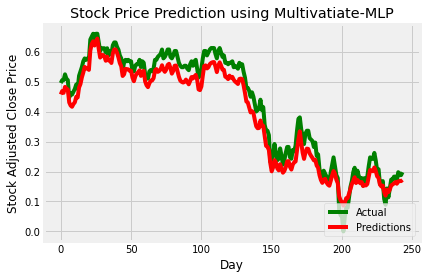

In [37]:
plt.plot(y_mlp_test, color= 'green')
plt.plot(predicted_mlp, color='red')
plt.title("Stock Price Prediction using Multivatiate-MLP")
plt.xlabel("Day")
plt.ylabel("Stock Adjusted Close Price")
plt.legend(['Actual','Predictions'], loc='lower right')
plt.show()